In [27]:
import pandas as pd
import numpy as np
import sklearn
sklearn.set_config(transform_output="pandas")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import Lasso
from catboost import CatBoostRegressor

### Загрузка датасетов

In [28]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Базовая визуализация


<Axes: title={'center': 'Распределение цен на дома'}, xlabel='Price', ylabel='Count'>

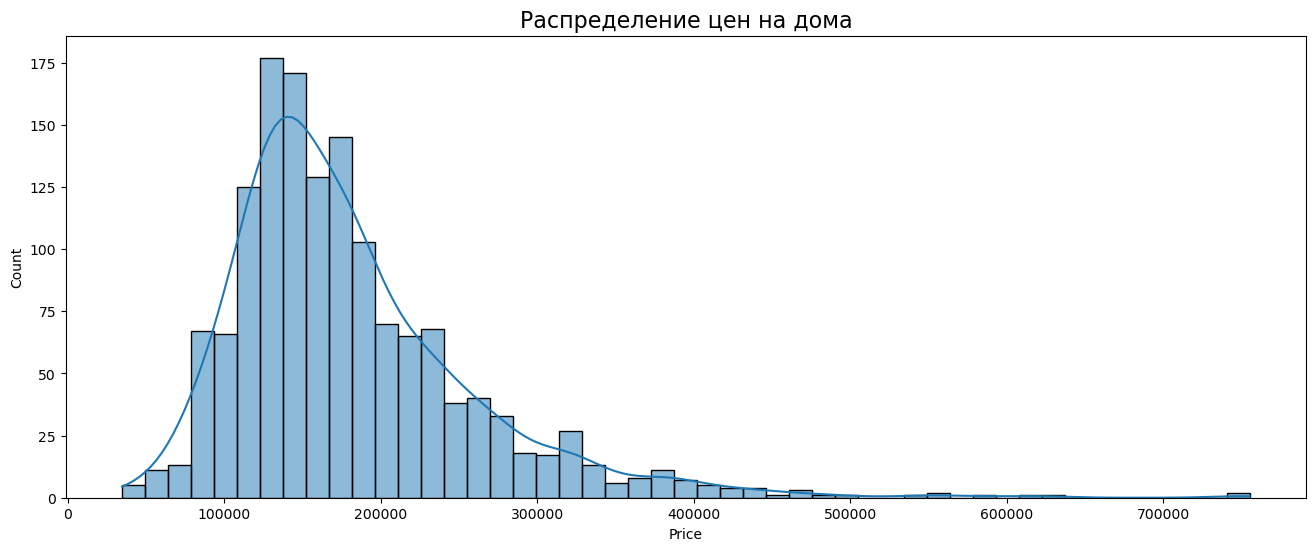

In [29]:
plt.figure(figsize=(16,6))
plt.title('Распределение цен на дома', fontsize=16)
plt.xlabel('Price')
sns.histplot(train['SalePrice'], kde=True)


In [30]:
x_train, y_train = train.drop('SalePrice',axis=1), np.log(train['SalePrice'])

### Объединение датасетов

In [31]:
df_merged = pd.concat([train, test], axis=0, ignore_index=True)


In [32]:
columns_to_drop = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'Id']

my_imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', columns_to_drop),
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), ['LotFrontage', 'Electrical', 'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'GarageCars', 'SaleType']),
        ('num_imputer_0', SimpleImputer(strategy='constant', fill_value='0'), ['MasVnrType', 'BsmtUnfSF' ,'BsmtQual', 'MasVnrArea', 'BsmtExposure', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']),
        ('num_imputer_mean', SimpleImputer(strategy='mean'), ['BsmtFinSF2','BsmtFinSF1', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageArea'])
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)

# категориальный колонки 
cat_columns = [
    'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual','GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'
]  
# численныые колонки за вычетом SalePrice для нормализации
num_columns = [
       'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'
       ] 
# колонки для ordinal_encoding только с двумя вариантами данных 
ordinal_encoding_columns = [
    'Street', 'Utilities', 'CentralAir'
] 
one_hot_encoding_columns = [col for col in cat_columns if col not in ordinal_encoding_columns] # колонки для one_hot_encoding


scaler_and_encoder = ColumnTransformer(
    transformers=[
        ('original encoding', OrdinalEncoder(), ordinal_encoding_columns),
        ('one_hot_encoding', OneHotEncoder(sparse_output=False), one_hot_encoding_columns),
        ('scaling', StandardScaler(), num_columns)
    ],
    verbose_feature_names_out=False, 
    remainder= 'passthrough' 
)

preprocessor = Pipeline(
    [
        ('imputer_and_dropper', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder)
    ]
)

In [33]:

x = preprocessor.fit_transform(df_merged) # подготовленные данные для ML

### РазЪединение


In [34]:
train_ml_ready, test_ml_ready = x[x['SalePrice'].notna()], (x[x['SalePrice'].isna()]) # разделение датасетов на train и test по колонке SalePrice


test_ml_ready = test_ml_ready.drop('SalePrice', axis=1)

x_train, y_train = train_ml_ready.drop('SalePrice', axis=1), train_ml_ready['SalePrice'] # разделение на фитчи и таргет

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

### Оптюна для бедных


In [59]:
import logging
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error
logging.getLogger('catboost').setLevel(logging.CRITICAL)
logging.getLogger('optuna').setLevel(logging.CRITICAL)


def object_cat(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
    }
    catboost_model = CatBoostRegressor(eval_metric='RMSE', random_seed=42, silent=True, **params)
    catboost_model.fit(x_train, y_train)
    cat_predict = catboost_model.predict(x_valid)
    score = np.sqrt(mean_squared_log_error(y_valid, cat_predict))
    return score

study_catboost = optuna.create_study(direction="minimize")
study_catboost.optimize(object_cat, n_trials=50)


best_catboost_model = CatBoostRegressor(**study_catboost.best_params, eval_metric='RMSE', random_seed=42, silent=True)
best_catboost_model.fit(x_train, y_train)
cat_predict = best_catboost_model.predict(x_valid)


print("Best CatBoost Parameters:", study_catboost.best_params)
print("Best CatBoost RMSLE Score:", study_catboost.best_value)
print("MAE:", mean_absolute_error(y_valid, cat_predict))
print("R²:", r2_score(y_valid, cat_predict))
print("RMLSE:", np.sqrt(mean_squared_log_error(y_valid, cat_predict)))

KeyboardInterrupt: 

In [42]:
ml_cat = CatBoostRegressor(iterations=150, learning_rate=0.14651213408043404, max_depth=5)
ml_cat.fit(x_train, y_train)
cat_predict = ml_cat.predict(x_valid)
rmse = np.sqrt(mean_squared_log_error(y_valid, cat_predict))
mae = mean_absolute_error(y_valid, cat_predict)
r2 = r2_score(y_valid, cat_predict)
rmlse = np.sqrt(mean_squared_log_error(y_valid, cat_predict))
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)
print("RMLSE:", rmlse)

0:	learn: 70173.1356847	total: 2.14ms	remaining: 319ms
1:	learn: 64437.2225424	total: 3.96ms	remaining: 293ms
2:	learn: 59110.9022345	total: 5.74ms	remaining: 281ms
3:	learn: 54629.8465909	total: 7.73ms	remaining: 282ms
4:	learn: 50337.1759104	total: 9.43ms	remaining: 273ms
5:	learn: 47538.8086895	total: 10.9ms	remaining: 262ms
6:	learn: 44762.1816399	total: 12.8ms	remaining: 261ms
7:	learn: 42125.9800282	total: 14.2ms	remaining: 253ms
8:	learn: 39959.8697030	total: 15.7ms	remaining: 246ms
9:	learn: 38272.6429842	total: 17.1ms	remaining: 240ms
10:	learn: 36610.2932222	total: 19.1ms	remaining: 242ms
11:	learn: 35219.0008109	total: 21.4ms	remaining: 246ms
12:	learn: 33733.2040379	total: 23.5ms	remaining: 248ms
13:	learn: 32593.1662665	total: 25.6ms	remaining: 248ms
14:	learn: 31624.9081329	total: 27.3ms	remaining: 245ms
15:	learn: 30639.0983976	total: 29.4ms	remaining: 246ms
16:	learn: 29588.7368121	total: 31.2ms	remaining: 244ms
17:	learn: 28993.1359987	total: 33.3ms	remaining: 244ms
18

### Оптюна для бедных 2

In [44]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error
logging.getLogger('voting').setLevel(logging.CRITICAL)
logging.getLogger('optuna').setLevel(logging.CRITICAL)

def object_voting(trial):
    # модели с гиперпараметрами
    model = LinearRegression()
    
  
    max_depth = trial.suggest_int('max_depth', 1, 10)
    model4 = DecisionTreeRegressor(max_depth=max_depth)
    
  
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    knn_model = KNeighborsRegressor(n_neighbors=n_neighbors)

  
    voting_regressor = VotingRegressor(estimators=[
        ('lr', model),
        ('dt', model4),
        ('knn', knn_model)
    ])


    voting_regressor.fit(x_train, y_train)

    
    voting_predict = voting_regressor.predict(x_valid)
    
   
    score = np.sqrt(mean_squared_log_error(y_valid, voting_predict))
    return score 

# Создание и оптимизация исследования Optuna
study_voting = optuna.create_study(direction="minimize")  
study_voting.optimize(object_voting, n_trials=50)

# Вывод лучших параметров и значения RMSLE
print("Best parameters: ", study_voting.best_params)
print("Best RMSLE: ", study_voting.best_value)



Best parameters:  {'max_depth': 7, 'n_neighbors': 3}
Best RMSLE:  0.14429223495268131


In [45]:
model1 = LinearRegression()
model4 = DecisionTreeRegressor(max_depth=7)  
knn_model = KNeighborsRegressor(n_neighbors=3)  

# Создание VotingRegressor
ml_voting = VotingRegressor(estimators=[
    ('lr', model1),
    ('dt', model4),
    ('knn', knn_model)
])

# Обучение модели
ml_voting.fit(x_train, y_train)
voting_predict = ml_voting.predict(x_valid)

# Вычисление метрик
mae = mean_absolute_error(y_valid, voting_predict)
r2 = r2_score(y_valid, voting_predict)
rmlse = np.sqrt(mean_squared_log_error(y_valid, voting_predict))

# Вывод результатов
print("MAE:", mae)
print("R²:", r2)
print("RMLSE:", rmlse)

MAE: 17634.562661357886
R²: 0.8827127548268047
RMLSE: 0.14668039439307803


In [57]:
predictions = ml_cat.predict(test_ml_ready)
submission = pd.DataFrame({
    "Id": test['Id'],
    "SalePrice": predictions
})
submission.to_csv("submission.csv", index=False)

(-0.5, 1251.5, 175.5, -0.5)

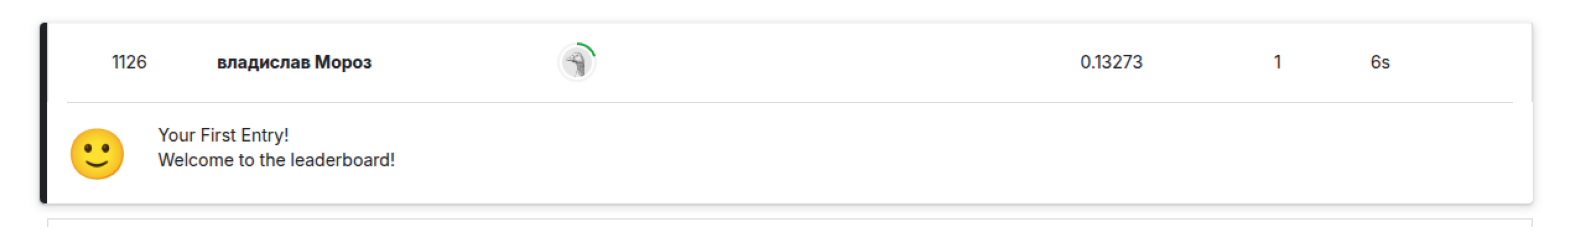

In [58]:
import matplotlib.image as mpimg
img = mpimg.imread('Снимок экрана от 2025-01-24 13-05-34.png')
plt.figure(figsize=(20,6))
plt.imshow(img)
plt.axis('off')

### Применение Лассо(не для ловли домашнего скота)

In [19]:
lasso = Lasso(alpha=0.1)  
lasso.fit(x_train, y_train)
coef_series = pd.Series(dict(zip(x_train.columns, lasso.coef_))).sort_values(key=lambda x: abs(x), ascending=False)



/home/vlad/Первая/house-prices-advanced-regression-techniques/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.582e+10, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


In [21]:

rf = RandomForestRegressor()
rf.fit(x_train, y_train)
rf_coef = pd.Series(dict(zip(x_train.columns, rf.feature_importances_))).sort_values(key=lambda x: abs(x), ascending=False)


In [ ]:
x_train['random'] = np.random.uniform(0,100, size=x_train.shape[0])
rf = RandomForestRegressor()

rf.fit(x_train, y_train)

pd.Series(dict(zip(x_train.columns, rf.feature_importances_))).sort_values(key=lambda x: abs(x), ascending=False)

OverallQual         0.548943
GrLivArea           0.129845
TotalBsmtSF         0.034559
1stFlrSF            0.031086
BsmtFinSF1          0.027486
                      ...   
RoofMatl_Membran    0.000000
Condition2_RRAn     0.000000
Electrical_Mix      0.000000
Condition1_RRNe     0.000000
SaleType_Oth        0.000000
Length: 283, dtype: float64

In [53]:
import shap
from catboost import CatBoostRegressor
shap.initjs()

In [55]:
import shap

model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(x_train, y_train, verbose=False, plot=False)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

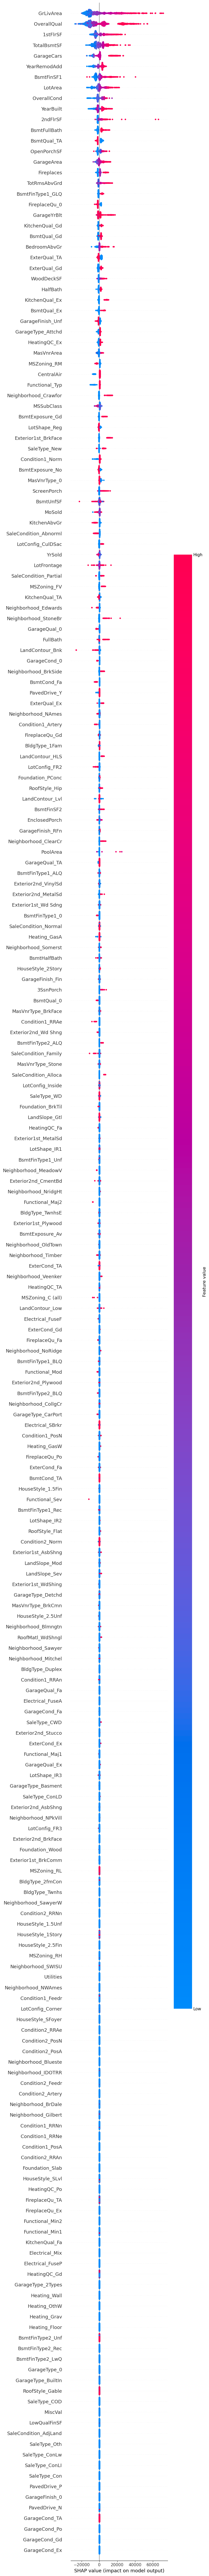

In [60]:
shap.summary_plot(shap_values, x_train, max_display=240)
shap.summary_plot(shap_values, x_train, max_display=50, show=False)
plt.savefig('shap_summary_plot.png', bbox_inches='tight')
plt.close()
